In [1]:
# Import things
%matplotlib inline
import matplotlib
#matplotlib.use('Agg')

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as md
import pandas as pd
from matplotlib import rcParams
import sys
from netCDF4 import Dataset, MFDataset,num2date,date2num
sys.path.append('/Users/heather/ICECAPS-ACE/DataParse/')

from utils import *

# Supress warnings for sake of log file
import warnings
warnings.filterwarnings("ignore")


rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams.update({'font.size': 14}) 
rcParams['axes.titlepad'] = 14 
rcParams['xtick.major.pad']='10'
rcParams['ytick.major.pad']='10'


In [52]:
# Netcdf location
dloc = '/Volumes/Data/ICECAPSarchive/ACE_netcdfs/'

# Start and stop date
start = pd.datetime(2019,12,1,0,0)
stop = pd.datetime(2019,12,31,0,0)
years = ['2019']
months = ['12']

# Plotting setup
myFmt = md.DateFormatter('%d/%m')
rule = md.DayLocator(interval=5)


In [53]:
# Get NOAA met data
met=pd.DataFrame()
for year in years:
    for month in months:
        w_dloc = '/Volumes/Data/ICECAPSarchive/Summit_Met/met_sum_insitu_1_obop_minute_%s_%s.txt'%(year,str(month).zfill(2))
        met = met.append(get_NOAA_met(w_dloc))

In [54]:
def get_nc(name,var_list,lev_list,years,months):
    file_list=[]
    for year in years: 
        for month in months: 
            file_list.append(dloc + '%s/ACE-tower_Summit_%s%s_%s_v1.nc'%(name,year,str(month).zfill(2),name))

    if len(file_list)>1:
        nc = MFDataset(file_list,'r',aggdim='time')
    elif len(file_list)==1:
        nc = Dataset(file_list[0],'r')
    else:
        print('No data')

    times = num2date(nc.variables['time'][:],nc.variables['time'].units)
    all_vars=[]
    for i in range(0,len(var_list)):  
        if lev_list[i]==-1:
            all_vars.append(nc.variables[var_list[i]][:])
        else:
            all_vars.append(nc.variables[var_list[i]][:,lev_list[i]])
                             
    return times, all_vars

    

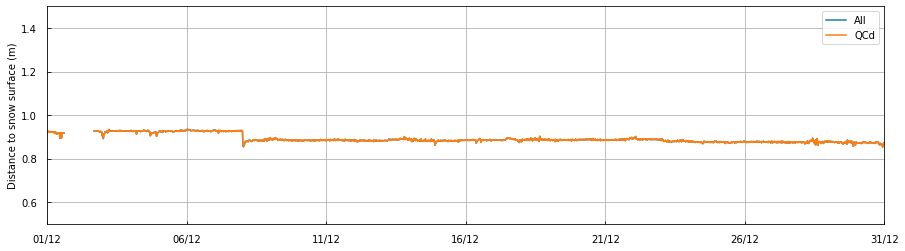

In [55]:
# Get snow height and plot

var_list=['distance_to_surface','qc_flag_snow_height']
lev_list=[-1,-1]
times,all_vars = get_nc('snow-height',var_list,lev_list,years,months)  
  
#QC
dist=all_vars[0]
qc=all_vars[1]
dist_qc = np.ma.masked_where(qc!=1,dist)
    
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(111)
ax1.grid(True)
ax1.plot(times,dist,label='All')
ax1.plot(times,dist_qc,label='QCd')
ax1.legend()
ax1.set_xlim(start,stop)
ax1.set_ylim(0.5,1.5)
ax1.set_ylabel('Distance to snow surface (m)')   

ax1.xaxis.set_major_formatter(myFmt)
ax1.xaxis.set_major_locator(rule)

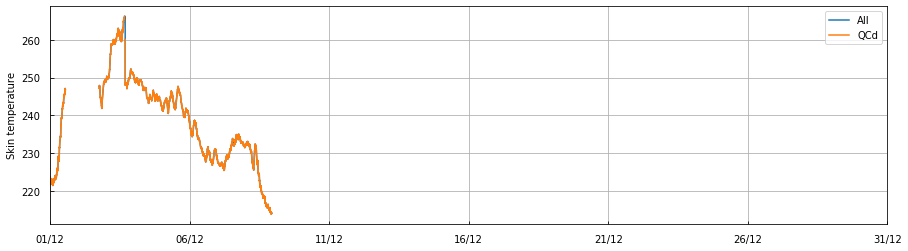

In [56]:
# Get skintemp and plot

var_list=['skin_temperature','qc_flag_skin_temperature']
lev_list=[-1,-1]
kt_times,[kt,qc] = get_nc('skin-temperature',var_list,lev_list,years,months)  

#QC
kt_qc = np.ma.masked_where(qc!=1,kt)

KTdf = pd.DataFrame({'KT':kt_qc},index=kt_times)
    
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(111)
ax1.grid(True)
ax1.plot(kt_times,kt,label='All')
ax1.plot(kt_times,kt_qc,label='QCd')
ax1.legend()
ax1.set_xlim(start,stop)
#ax1.set_ylim(0.5,1.5)
ax1.set_ylabel('Skin temperature')   

ax1.xaxis.set_major_formatter(myFmt)
ax1.xaxis.set_major_locator(rule)

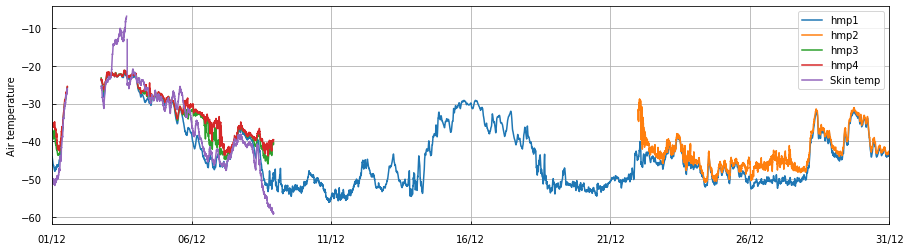

In [57]:
# Get temp profile

var_list=['air_temperature','air_temperature','air_temperature','air_temperature','qc_flag_surface_temperature','qc_flag_surface_temperature','qc_flag_surface_temperature','qc_flag_surface_temperature']
lev_list=[0,1,2,3,0,1,2,3]
var_alts = ['altitude','altitude','altitude','altitude']

hmp_times,[hmp1,hmp2,hmp3,hmp4,qc1,qc2,qc3,qc4] = get_nc('surface-temperature-profile',var_list,lev_list,years,months)
times,[hmp1_alt, hmp2_alt,hmp3_alt,hmp4_alt] = get_nc('surface-temperature-profile',var_alts,[0,1,2,3],years,months)

#QC
hmp1_qc = np.ma.masked_where(qc1==0,hmp1)
hmp2_qc = np.ma.masked_where(qc2==0,hmp2)
hmp3_qc = np.ma.masked_where(qc3==0,hmp3)
hmp4_qc = np.ma.masked_where(qc4==0,hmp4)

HMPdf = pd.DataFrame({'hmp1':hmp1_qc,'hmp2':hmp2_qc,'hmp3':hmp3_qc,'hmp4':hmp4_qc},index=hmp_times)
 
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(111)
ax1.grid(True)
#ax1.plot(times,hmp1)
#ax1.plot(times,hmp2)
#ax1.plot(times,hmp3)
#ax1.plot(times,hmp4)

ax1.plot(times,hmp1_qc-273.15,label='hmp1')
ax1.plot(times,hmp2_qc-273.15,label='hmp2')
ax1.plot(times,hmp3_qc-273.15,label='hmp3')
ax1.plot(times,hmp4_qc-273.15,label='hmp4')

ax1.plot(kt_times,kt_qc-273.15,label='Skin temp')

ax1.legend()
ax1.set_xlim(start,stop)
#ax1.set_ylim(0.5,1.5)
ax1.set_ylabel('Air temperature')   

ax1.xaxis.set_major_formatter(myFmt)
ax1.xaxis.set_major_locator(rule)

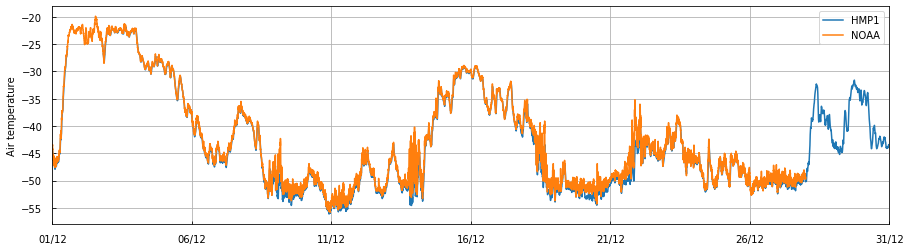

In [58]:

# plot 2m temp agains noaa temp

fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(111)
ax1.grid(True)
ax1.plot(times,hmp1_qc-273.15,label='HMP1')
ax1.plot(met.index,met['T'],label='NOAA')
ax1.legend()
ax1.set_xlim(start,stop)
#ax1.set_ylim(0.5,1.5)
ax1.set_ylabel('Air temperature')   

ax1.xaxis.set_major_formatter(myFmt)
ax1.xaxis.set_major_locator(rule)

Text(0, 0.5, 'Air temperature')

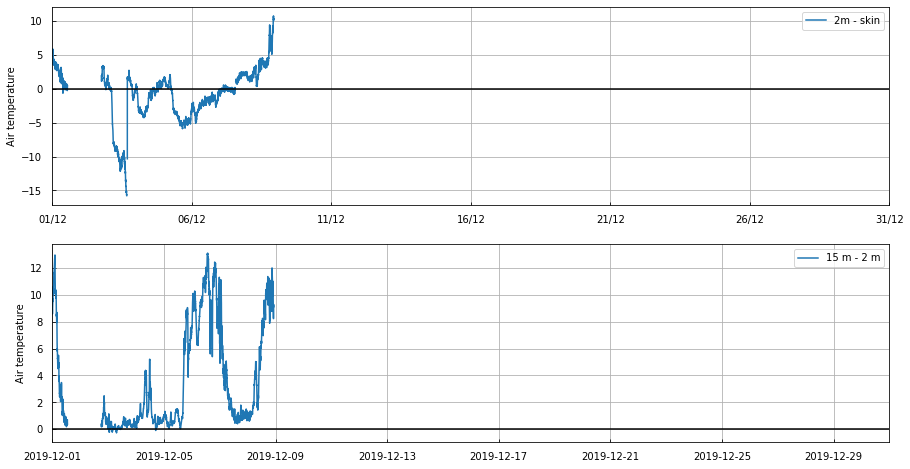

In [59]:
# plot 2m temp - skin temp

fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
ax1.grid(True)
ax1.plot((HMPdf['hmp1']-KTdf['KT']),label='2m - skin')
ax1.legend()
ax1.set_xlim(start,stop)
ax1.axhline(0,c='k')
#ax1.set_ylim(0.5,1.5)
ax1.set_ylabel('Air temperature')   

ax1.xaxis.set_major_formatter(myFmt)
ax1.xaxis.set_major_locator(rule)

# plot 15m - 2m

ax1 = fig.add_subplot(212)
ax1.grid(True)
ax1.plot((HMPdf['hmp4']-HMPdf['hmp1']),label='15 m - 2 m')
ax1.legend()
ax1.set_xlim(start,stop)
ax1.axhline(0,c='k')
#ax1.set_ylim(0.5,1.5)
ax1.set_ylabel('Air temperature')   

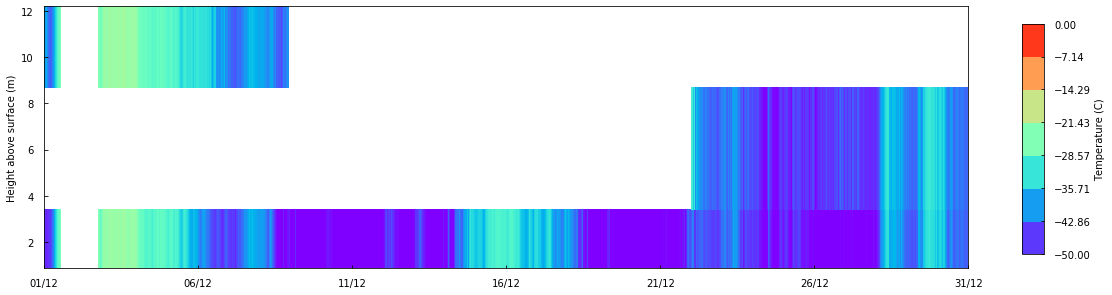

In [60]:
# Plots temperature height mesh

X = np.asarray([hmp1_qc,hmp2_qc,hmp3_qc,hmp4_qc])
alts = np.asarray([np.nanmean(hmp1_alt),np.nanmean(hmp2_alt),np.nanmean(hmp3_alt),np.nanmean(hmp4_alt)])
vmin = -50
vmax = 0

fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
ax1.grid(True)
rf = ax1.pcolor(hmp_times,alts,X-273.15,cmap='rainbow',vmax=vmax,vmin=vmin) 
ax1.set_ylabel('Height above surface (m)')
#ax1.legend()
ax1.set_xlim(start,stop)
#ax1.set_ylim(0.5,1.5)

ticks = np.linspace(vmin,vmax,8)

ax1.xaxis.set_major_formatter(myFmt)
ax1.xaxis.set_major_locator(rule)

fig.tight_layout()    
fig.subplots_adjust(right=0.9)
cbar_ax1 = fig.add_axes([0.95, 0.55, 0.02, 0.4])
#cbar_ax2 = fig.add_axes([0.95, 0.05, 0.02, 0.4])
fig.colorbar(rf,cax=cbar_ax1,label='Temperature (C)',ticks=ticks,boundaries=ticks)

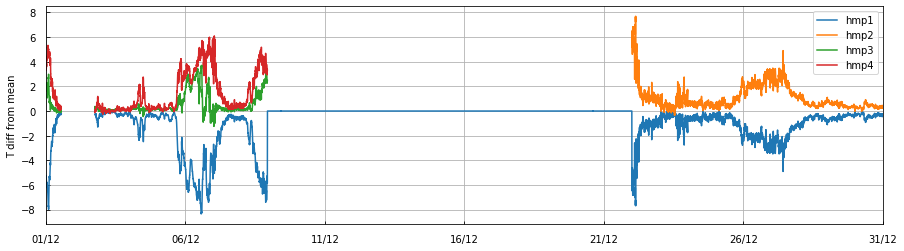

In [61]:
# Plots temp - profile mean

profile_meanT = np.nanmean(X,axis=0)

fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(111)
ax1.grid(True)

ax1.plot(times,(hmp1_qc-profile_meanT),label='hmp1')
ax1.plot(times,(hmp2_qc-profile_meanT),label='hmp2')
ax1.plot(times,(hmp3_qc-profile_meanT),label='hmp3')
ax1.plot(times,(hmp4_qc-profile_meanT),label='hmp4')

ax1.legend()
ax1.set_xlim(start,stop)
#ax1.set_ylim(0.5,1.5)
ax1.set_ylabel('T diff from mean')   

ax1.xaxis.set_major_formatter(myFmt)
ax1.xaxis.set_major_locator(rule)

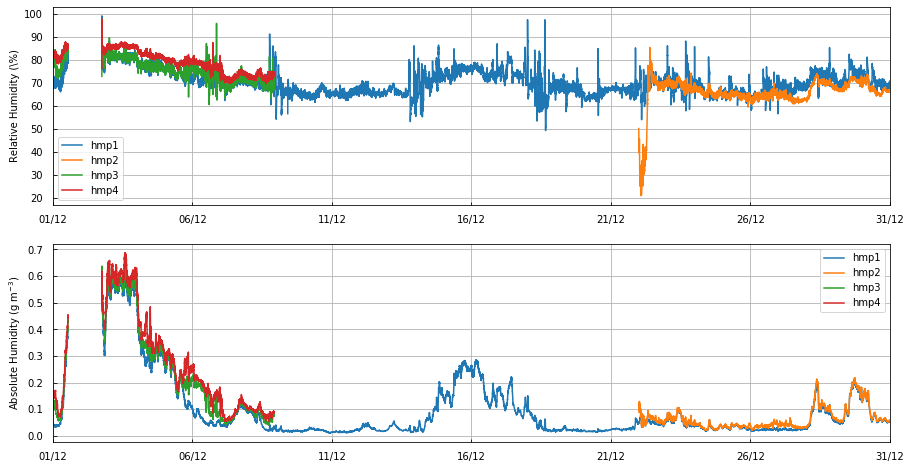

In [62]:
# Get moisture profile

var_list_rh=['relative_humidity','relative_humidity','relative_humidity','relative_humidity','qc_flag_surface_relative_humidity','qc_flag_surface_relative_humidity','qc_flag_surface_relative_humidity','qc_flag_surface_relative_humidity']
var_list_a=['absolute_humidity','absolute_humidity','absolute_humidity','absolute_humidity']
lev_list=[0,1,2,3,0,1,2,3]
var_alts = ['altitude','altitude','altitude','altitude']

rh_times,[rh1,rh2,rh3,rh4,qc1,qc2,qc3,qc4] = get_nc('surface-moisture-profile',var_list_rh,lev_list,years,months)
times,[a1,a2,a3,a4] = get_nc('surface-moisture-profile',var_list_a,[0,1,2,3],years,months)
times,[hmp1_alt, hmp2_alt,hmp3_alt,hmp4_alt] = get_nc('surface-moisture-profile',var_alts,[0,1,2,3],years,months)

#QC
rh1_qc = np.ma.masked_where(qc1==0,rh1)
rh2_qc = np.ma.masked_where(qc2==0,rh2)
rh3_qc = np.ma.masked_where(qc3==0,rh3)
rh4_qc = np.ma.masked_where(qc4==0,rh4)

a1_qc = np.ma.masked_where(qc1==0,a1)
a2_qc = np.ma.masked_where(qc2==0,a2)
a3_qc = np.ma.masked_where(qc3==0,a3)
a4_qc = np.ma.masked_where(qc4==0,a4)

RHdf = pd.DataFrame({'hmp1':rh1_qc,'hmp2':rh2_qc,'hmp3':rh3_qc,'hmp4':rh4_qc},index=rh_times)
 
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
ax1.grid(True)
#ax1.plot(times,hmp1)
#ax1.plot(times,hmp2)
#ax1.plot(times,hmp3)
#ax1.plot(times,hmp4)

ax1.plot(times,rh1_qc,label='hmp1')
ax1.plot(times,rh2_qc,label='hmp2')
ax1.plot(times,rh3_qc,label='hmp3')
ax1.plot(times,rh4_qc,label='hmp4')

ax1.legend()
ax1.set_xlim(start,stop)
#ax1.set_ylim(0.5,1.5)
ax1.set_ylabel('Relative Humidity (\%)')   

ax1.xaxis.set_major_formatter(myFmt)
ax1.xaxis.set_major_locator(rule)

ax2 = fig.add_subplot(212)
ax2.grid(True)

ax2.plot(times,a1_qc,label='hmp1')
ax2.plot(times,a2_qc,label='hmp2')
ax2.plot(times,a3_qc,label='hmp3')
ax2.plot(times,a4_qc,label='hmp4')

ax2.legend()
ax2.set_xlim(start,stop)
#ax1.set_ylim(0.5,1.5)
ax2.set_ylabel('Absolute Humidity (g m$^{-3}$)')   

ax2.xaxis.set_major_formatter(myFmt)
ax2.xaxis.set_major_locator(rule)

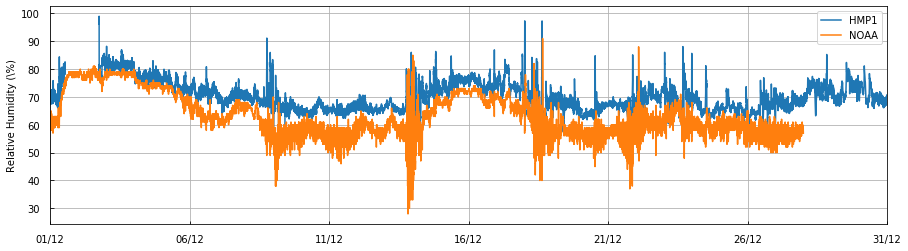

In [63]:
# plot 2m rh agains noaa rh

fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(111)
ax1.grid(True)
ax1.plot(times,rh1_qc,label='HMP1')
ax1.plot(met.index,met['RH'],label='NOAA')
ax1.legend()
ax1.set_xlim(start,stop)
#ax1.set_ylim(0.5,1.5)
ax1.set_ylabel('Relative Humidity (\%)')   

ax1.xaxis.set_major_formatter(myFmt)
ax1.xaxis.set_major_locator(rule)

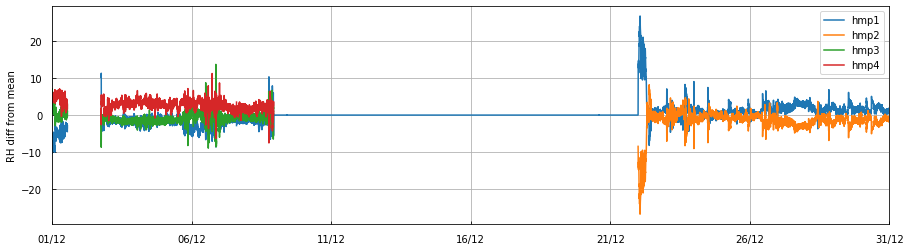

In [64]:
# Plots rh - profile mean

profile_meanRH = np.nanmean((np.asarray([rh1_qc,rh2_qc,rh3_qc,rh4_qc])),axis=0)

fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(111)
ax1.grid(True)

ax1.plot(times,(rh1_qc-profile_meanRH),label='hmp1')
ax1.plot(times,(rh2_qc-profile_meanRH),label='hmp2')
ax1.plot(times,(rh3_qc-profile_meanRH),label='hmp3')
ax1.plot(times,(rh4_qc-profile_meanRH),label='hmp4')

ax1.legend()
ax1.set_xlim(start,stop)
#ax1.set_ylim(0.5,1.5)
ax1.set_ylabel('RH diff from mean')   

ax1.xaxis.set_major_formatter(myFmt)
ax1.xaxis.set_major_locator(rule)

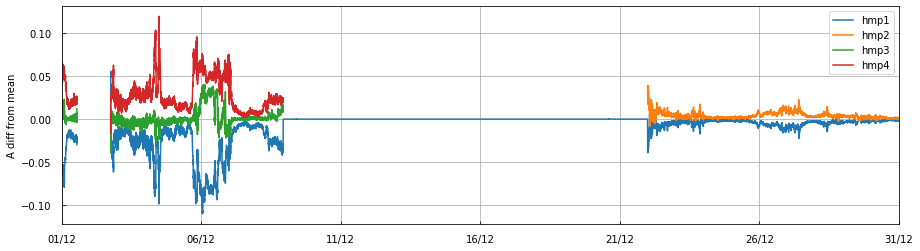

In [65]:
# Plots A - profile mean

profile_meanA = np.nanmean((np.asarray([a1_qc,a2_qc,a3_qc,a4_qc])),axis=0)

fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(111)
ax1.grid(True)

ax1.plot(times,(a1_qc-profile_meanA),label='hmp1')
ax1.plot(times,(a2_qc-profile_meanA),label='hmp2')
ax1.plot(times,(a3_qc-profile_meanA),label='hmp3')
ax1.plot(times,(a4_qc-profile_meanA),label='hmp4')

ax1.legend()
ax1.set_xlim(start,stop)
#ax1.set_ylim(0.5,1.5)
ax1.set_ylabel('A diff from mean')   

ax1.xaxis.set_major_formatter(myFmt)
ax1.xaxis.set_major_locator(rule)

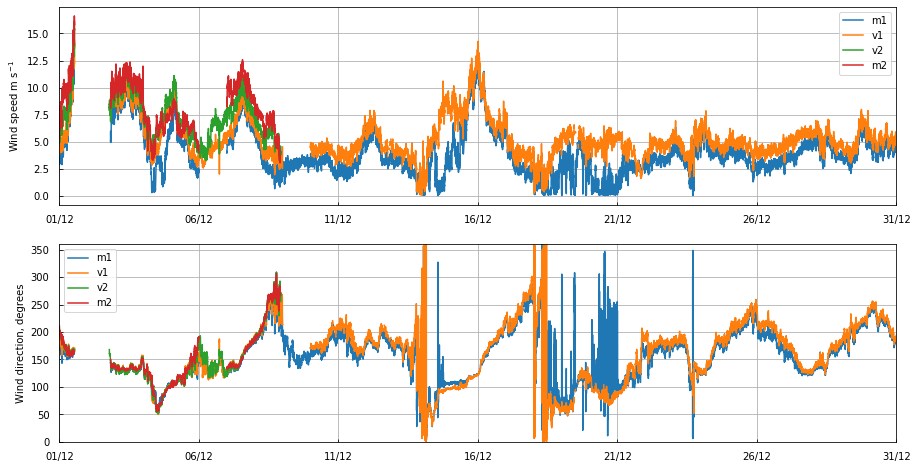

In [66]:
# Get wind profile

var_list_ws=['wind_speed','wind_speed','wind_speed','wind_speed','qc_flag','qc_flag','qc_flag','qc_flag']
var_list_wd=['wind_from_direction','wind_from_direction','wind_from_direction','wind_from_direction']
lev_list=[0,1,2,3,0,1,2,3]
var_alts = ['altitude','altitude','altitude','altitude']

ws_times,[ws1,ws2,ws3,ws4,qc1,qc2,qc3,qc4] = get_nc('surface-winds-profile',var_list_ws,lev_list,years,months)
times,[wd1,wd2,wd3,wd4] = get_nc('surface-winds-profile',var_list_wd,[0,1,2,3],years,months)
times,[w1_alt, w2_alt,w3_alt,w4_alt] = get_nc('surface-winds-profile',var_alts,[0,1,2,3],years,months)

#QC
ws1_qc = np.ma.masked_where(qc1==0,ws1)
ws2_qc = np.ma.masked_where(qc2==0,ws2)
ws3_qc = np.ma.masked_where(qc3==0,ws3)
ws4_qc = np.ma.masked_where(qc4==0,ws4)

wd1_qc = np.ma.masked_where(qc1==0,wd1)
wd2_qc = np.ma.masked_where(qc2==0,wd2)
wd3_qc = np.ma.masked_where(qc3==0,wd3)
wd4_qc = np.ma.masked_where(qc4==0,wd4)

#RHdf = pd.DataFrame({'hmp1':rh1_qc,'hmp2':rh2_qc,'hmp3':rh3_qc,'hmp4':rh4_qc},index=rh_times)
 
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
ax1.grid(True)

ax1.plot(times,ws1_qc,label='m1')
ax1.plot(times,ws2_qc,label='v1')
ax1.plot(times,ws3_qc,label='v2')
ax1.plot(times,ws4_qc,label='m2')

ax1.legend()
ax1.set_xlim(start,stop)
#ax1.set_ylim(0.5,1.5)
ax1.set_ylabel('Wind speed m s$^{-1}$')   

ax1.xaxis.set_major_formatter(myFmt)
ax1.xaxis.set_major_locator(rule)

ax2 = fig.add_subplot(212)
ax2.grid(True)

ax2.plot(times,wd1_qc,label='m1')
ax2.plot(times,wd2_qc,label='v1')
ax2.plot(times,wd3_qc,label='v2')
ax2.plot(times,wd4_qc,label='m2')

ax2.legend()
ax2.set_xlim(start,stop)
ax2.set_ylim(0,360)
ax2.set_ylabel('Wind direction, degrees')   

ax2.xaxis.set_major_formatter(myFmt)
ax2.xaxis.set_major_locator(rule)

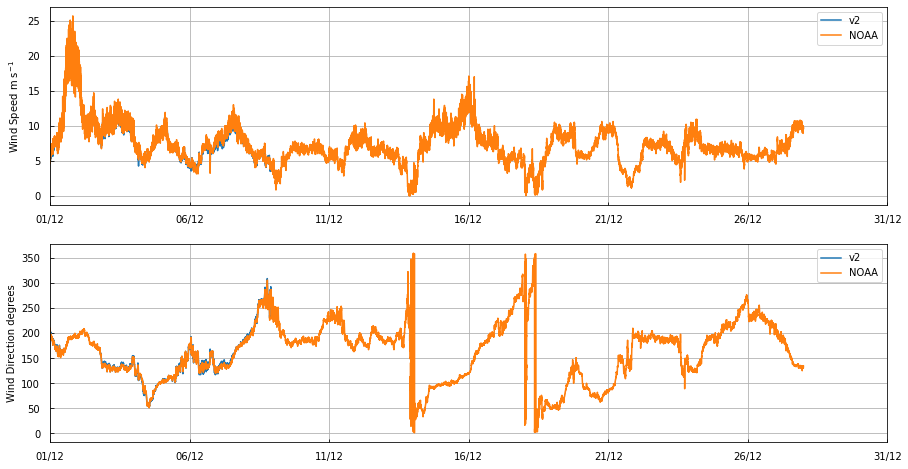

In [67]:
# plot winds agains noaa

fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
ax1.grid(True)
ax1.plot(times,ws3_qc,label='v2')
ax1.plot(met.index,met['ws'],label='NOAA')
ax1.legend()
ax1.set_xlim(start,stop)
#ax1.set_ylim(0.5,1.5)
ax1.set_ylabel('Wind Speed m s$^{-1}$')   

ax1.xaxis.set_major_formatter(myFmt)
ax1.xaxis.set_major_locator(rule)

ax2 = fig.add_subplot(212)
ax2.grid(True)
ax2.plot(times,wd3_qc,label='v2')
ax2.plot(met.index,met['wd'],label='NOAA')
ax2.legend()
ax2.set_xlim(start,stop)
#ax1.set_ylim(0.5,1.5)
ax2.set_ylabel('Wind Direction degrees')   

ax2.xaxis.set_major_formatter(myFmt)
ax2.xaxis.set_major_locator(rule)

In [68]:
u,v = wind_to_uv(ws3_qc, wd3_qc)

In [69]:
# plot peak wind altitude

profile_wind = np.asarray([ws1_qc,ws2_qc,ws3_qc,ws4_qc])
wind_alts = np.asarray([w1_alt,w2_alt,w3_alt,w4_alt])

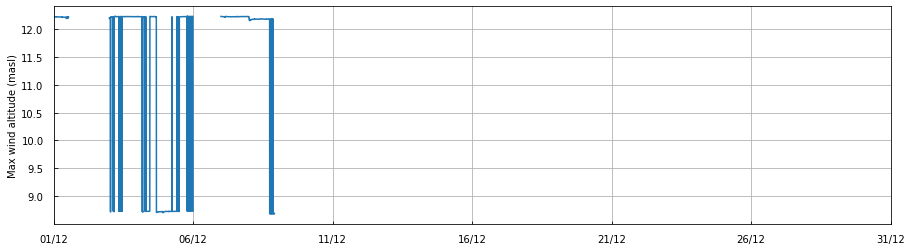

In [70]:
# Plot max wind alt

max_alt = []
for i in range(0,len(times)):
    ind = np.where(profile_wind[:,i]==np.max(profile_wind[:,i]))[0]
    try:
        max_alt.append(wind_alts[ind[0],i])
    except:
        max_alt.append(np.nan)
        
fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(111)
ax1.grid(True)
ax1.plot(times,max_alt)
ax1.set_xlim(start,stop)
#ax1.set_ylim(0.5,1.5)
ax1.set_ylabel('Max wind altitude (masl)')   

ax1.xaxis.set_major_formatter(myFmt)
ax1.xaxis.set_major_locator(rule)

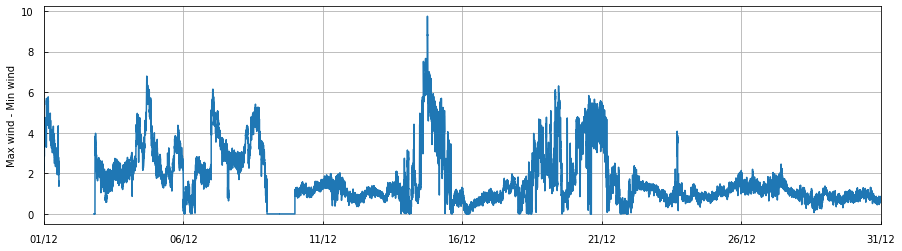

In [71]:
# Plot max wind speed - min wind speed

shear = np.nanmax(profile_wind,axis=0) - np.nanmin(profile_wind,axis=0)

fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(111)
ax1.grid(True)
ax1.plot(times,shear)
ax1.set_xlim(start,stop)
#ax1.set_ylim(0.5,1.5)
ax1.set_ylabel('Max wind - Min wind')   

ax1.xaxis.set_major_formatter(myFmt)
ax1.xaxis.set_major_locator(rule)

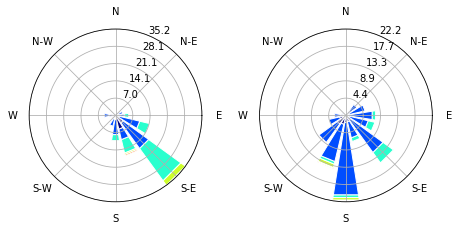

In [72]:
# plot wind rose - compare with noaa. 
from windrose import WindroseAxes
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(8,8))
#ax1 = plt.subplot(211)
rect1=[0.6,0.6,0.3,0.3] # have to be calculated with the others axes
rect2=[1.0,0.6,0.3,0.3]
wa = WindroseAxes(fig,rect1)
wa2 = WindroseAxes(fig,rect2)
fig.add_axes(wa)
fig.add_axes(wa2)
wa2.bar(met['wd'], met['ws'], normed=True, opening=0.8, edgecolor='white')
wa.bar(wd3_qc, ws3_qc, normed=True, opening=0.8, edgecolor='white')
#ax1.set_legend()